In [1]:
from sklearn import datasets, linear_model, metrics, preprocessing
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
from math import e
import pandas as pd

In [2]:
#ustawienia
time_multiplicator = 100
seed = 244810
samples = 2410

In [3]:
XY,C  = datasets.make_classification(n_features=2,n_clusters_per_class=1,n_redundant=0,n_samples=samples, random_state=seed,  )

In [4]:
from sklearn.model_selection import train_test_split
XY_train, XY_test, C_train, C_test = train_test_split(XY, C, test_size=0.2, random_state=0)

In [5]:
def standarize(arr):
    for col in range(arr.shape[1]):
        xmean = np.mean( arr[:,col])
        xstd = np.std( arr[:,col])
        arr[:,col] = (arr[:,col] - xmean)/xstd
    return arr    
    
def normalize(arr):
    for col in range(arr.shape[1]):
        xmin = min( arr[:,col])
        xmax = max( arr[:,col])
        arr[:,col] = (arr[:,col] - xmin )/(xmax-xmin)
    
    return arr        
    
XY_train = normalize(XY_train)
XY_test = normalize(XY_test)




# Sklearn

In [6]:
sk_time = time.time()
for i in range(time_multiplicator):
    sk_log_ans= linear_model.LogisticRegression().fit(XY_train,C_train)
sk_time = (time.time() - sk_time)/time_multiplicator 


In [7]:
sk_pred = sk_log_ans.predict(XY_test)

# Własna

In [8]:
def sigmoid(x):
    b=1
    return 1/(1+np.exp(-x*b))

In [9]:
def mse_cost(predicted, actual):
    return np.mean((predicted - actual)**2)

In [10]:
class my_log_reg:
    def __init__(self, learning_rate: float = 0.5, iterations: int = 100, error: float = 1e-5):
        self.learning_rate=learning_rate
        self.iterations = iterations
        self.error = error
        self.coef_= None
        self.intrecept_ = None
        self.costs = []
        self.done_iter = 0
    
    def fit(self, XY,C):
        if self.coef_ is None:
            self.coef_ = np.random.normal(loc = 1, scale=0.15, size=(1, XY.shape[1]))
            self.intrecept_ = np.random.normal(loc = 1, scale=0.15, size=1)
            
        C = C.reshape(-1,1)
        n=XY.shape[0]
        
        for i in range(self.iterations):
            preds = sigmoid(XY.dot(self.coef_.T) + self.intrecept_)
            cost = mse_cost(preds, C)
            
            dW = 1/n * np.dot((preds-C).T,XY)
            dB = 1/n *np.sum(preds -C)
        
            self.coef_ = self.coef_ - self.learning_rate * dW
            self.intrecept_ = self.intrecept_ - self.learning_rate * dB
            
            self.costs.append(cost)
            self.done_iter = i
            
            if len(self.costs) >= 2 and self.costs[-2] - self.costs[-1] < self.error:
                break
                
        return self
        
    def decision(self, XY):
        return sigmoid(XY.dot(self.coef_.T)+self.intrecept_)
    
    def predict(self, XY):
        return np.where(self.decision(XY) >= 0.5, 1, 0)
    

In [11]:
my_time = time.time()
for i in range(time_multiplicator):
    my_model = my_log_reg(learning_rate=1, iterations= 100, error= 2e-4)
    my_model.fit(XY_train, C_train)

my_time = (time.time() - my_time)/time_multiplicator 

In [12]:
my_pred = my_model.predict(XY_test)

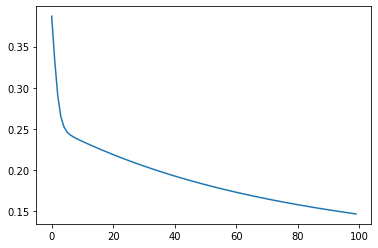

In [13]:
plt.plot(my_model.costs)


# Porównanie

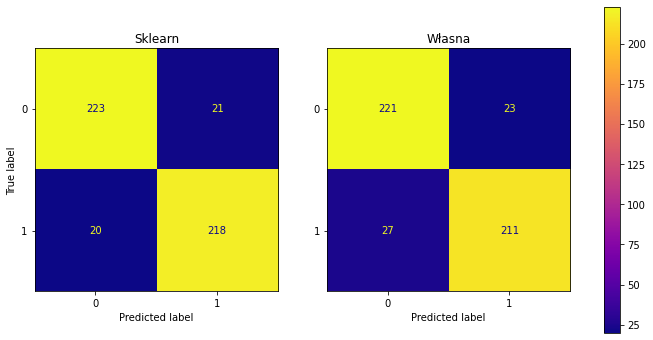

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))

sk_cm = metrics.confusion_matrix(C_test, sk_pred)
sk_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=sk_cm)
sk_disp.plot(ax=ax1 ,cmap='plasma')
sk_disp.ax_.set_title('Sklearn')
sk_disp.im_.colorbar.remove()

my_cm = metrics.confusion_matrix(C_test, my_pred)
my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
my_disp.plot(ax=ax2 ,cmap='plasma')
my_disp.ax_.set_title('Własna')
my_disp.im_.colorbar.remove()
my_disp.ax_.set_ylabel('')


fig.colorbar(sk_disp.im_, ax=(ax1, ax2))

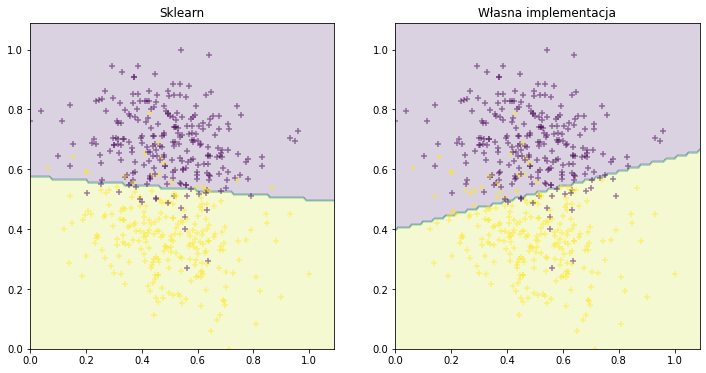

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))

mesh = np.meshgrid(np.arange(0, 1.1, 0.01), np.arange(0, 1.1, 0.01))[0]
sk_predict = sk_log_ans.predict(np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)

ax1.set_title("Sklearn")
ax1.contourf(mesh, mesh.T, sk_predict, alpha=0.2)
ax1.scatter(XY_test[:, 0], XY_test[:, 1], c=C_test+1, marker="+", alpha=0.5)

my_predict = np.array(my_model.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)
ax2.set_title("Własna implementacja")
ax2.contourf(mesh, mesh.T, my_predict, alpha=0.2)
ax2.scatter(XY_test[:, 0], XY_test[:, 1], c=C_test+1, marker="+", alpha=0.5)


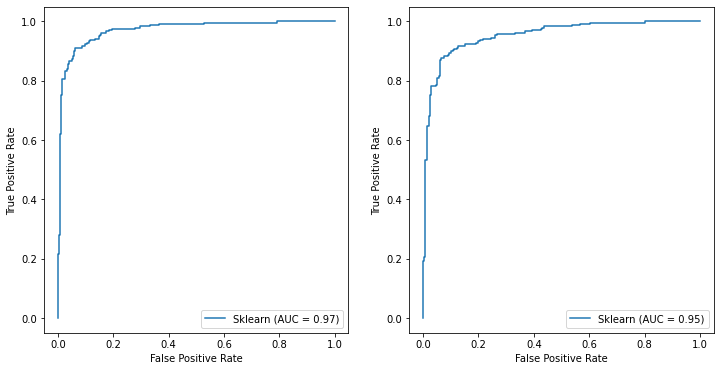

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))

fpr, tpr, thresholds = metrics.roc_curve(C_test, sk_log_ans.decision_function(XY_test))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Sklearn')
display.plot(ax=ax1)

fpr, tpr, thresholds = metrics.roc_curve(C_test, my_model.decision(XY_test))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Sklearn')
display.plot(ax=ax2)

In [17]:
print("Sklearn czułość: ",sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0]))
print("Wlasny  czułość: ",my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]))
print()
print("Sklearn specyficzność: ",sk_cm[1][1]/(sk_cm[0][0]+sk_cm[1][1]))
print("Wlasny  specyficzność: ",my_cm[1][1]/(my_cm[0][0]+my_cm[1][1]))
print()
print("Sklearn skuteczność: ",metrics.accuracy_score(sk_pred, C_test))
print("Wlasny  skuteczność: ",metrics.accuracy_score(my_pred, C_test))
print()
print("Sklearn czas: {:f}".format(sk_time))
print("Wlasny  czas: {:f}".format(my_time))

Sklearn czułość:  0.9176954732510288
Wlasny  czułość:  0.8911290322580645

Sklearn specyficzność:  0.4943310657596372
Wlasny  specyficzność:  0.48842592592592593

Sklearn skuteczność:  0.9149377593360996
Wlasny  skuteczność:  0.8962655601659751

Sklearn czas: 0.002871
Wlasny  czas: 0.006561


## Wnioski
- dobierając ilość iteracji, wielkość kroku uczącego oraz wartość błędu możemy uzyskać zbliżone parametry modelu
- Zmiana powyższych parametrów wpłynie na czas uczenia modelu
- Parametru modalu można dobrać w taki sposób aby uczuł się szybciej niż sklearn

### Porównanie dla moons

In [18]:
moons, moons_c = datasets.make_moons(n_samples=samples, noise = 0.1, random_state=seed)

M_train, M_test, mc_train, mc_test = train_test_split(moons, moons_c, test_size=0.2, random_state=0)

M_train = standarize(M_train)
M_test = standarize(M_test)



In [19]:
M_train = PolynomialFeatures(degree=3, include_bias=False).fit_transform(M_train)
M_test = PolynomialFeatures(degree=3, include_bias=False).fit_transform(M_test)

In [20]:
msk_time = time.time()
for i in range(time_multiplicator):
    msk_model= linear_model.LogisticRegression()
    msk_model.fit(M_train,mc_train)
msk_time = (time.time() - msk_time)/time_multiplicator 

msk_pred = msk_model.predict(M_test)

In [21]:
mmy_time = time.time()
for i in range(time_multiplicator):
    mmy_model = my_log_reg(learning_rate=0.5, iterations= 200, error= 2e-5)
    mmy_model.fit(M_train, mc_train)

mmy_time = (time.time() - mmy_time)/time_multiplicator 

mmy_pred = mmy_model.predict(M_test)

In [22]:
xmin = np.min(M_test[:,0])
xmax = np.max(M_test[:,0])
ymin = np.min(M_test[:,1])
ymax = np.max(M_test[:,1])

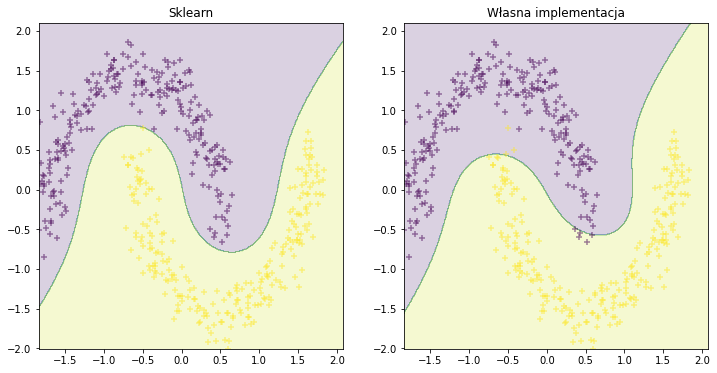

In [23]:
xx, yy = np.meshgrid(np.arange(xmin,xmax+0.25,0.01),np.arange(ymin,ymax+0.25,0.01))
mesh = np.c_[xx.ravel(), yy.ravel()]

mesh = PolynomialFeatures(degree=3, include_bias=False).fit_transform(mesh)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))

sk_ans = msk_model.predict(mesh).reshape(xx.shape)
ax1.set_title("Sklearn")
ax1.contourf(xx,yy,sk_ans, alpha=0.2)
ax1.scatter(M_test[:,0],M_test[:,1], c=mc_test,marker="+", alpha=0.5)

my_ans = mmy_model.predict(mesh).reshape(xx.shape)
ax2.set_title("Własna implementacja")
ax2.contourf(xx,yy,my_ans, alpha=0.2)
ax2.scatter(M_test[:,0],M_test[:,1], c=mc_test,marker="+", alpha=0.5)

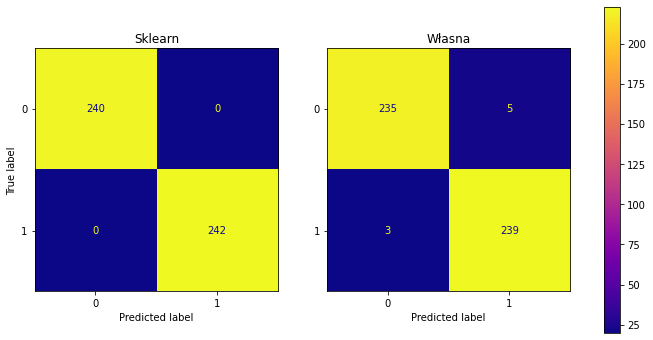

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))

msk_cm = metrics.confusion_matrix(mc_test, msk_pred)
msk_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=msk_cm)
msk_disp.plot(ax=ax1 ,cmap='plasma')
msk_disp.ax_.set_title('Sklearn')
msk_disp.im_.colorbar.remove()

mmy_cm = metrics.confusion_matrix(mc_test, mmy_pred)
mmy_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=mmy_cm)
mmy_disp.plot(ax=ax2 ,cmap='plasma')
mmy_disp.ax_.set_title('Własna')
mmy_disp.im_.colorbar.remove()
mmy_disp.ax_.set_ylabel('')


fig.colorbar(sk_disp.im_, ax=(ax1, ax2))

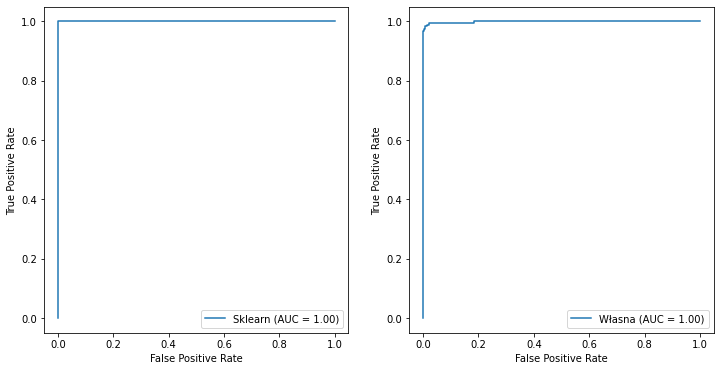

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))

fpr, tpr, thresholds = metrics.roc_curve(mc_test, msk_model.decision_function(M_test))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Sklearn')
display.plot(ax=ax1)

fpr, tpr, thresholds = metrics.roc_curve(mc_test, mmy_model.decision(M_test))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Własna')
display.plot(ax=ax2)

In [26]:
print("Sklearn czułość: ",msk_cm[0][0]/(msk_cm[0][0]+msk_cm[1][0]))
print("Wlasny  czułość: ",mmy_cm[0][0]/(mmy_cm[0][0]+mmy_cm[1][0]))
print()
print("Sklearn specyficzność: ",msk_cm[1][1]/(msk_cm[0][0]+msk_cm[1][1]))
print("Wlasny  specyficzność: ",mmy_cm[1][1]/(mmy_cm[0][0]+mmy_cm[1][1]))
print()
print("Sklearn skuteczność: ",metrics.accuracy_score(msk_pred, mc_test))
print("Wlasny  skuteczność: ",metrics.accuracy_score(mmy_pred, mc_test))
print()
print("Sklearn czas: {:f}".format(msk_time))
print("Wlasny  czas: {:f}".format(mmy_time))

Sklearn czułość:  1.0
Wlasny  czułość:  0.9873949579831933

Sklearn specyficzność:  0.5020746887966805
Wlasny  specyficzność:  0.5042194092827004

Sklearn skuteczność:  1.0
Wlasny  skuteczność:  0.983402489626556

Sklearn czas: 0.008922
Wlasny  czas: 0.035158


# Rain

In [27]:
import warnings
warnings.filterwarnings('ignore')

rain = pd.read_csv('weatherAUS.csv', delimiter = ',')
rain = rain.loc[:, rain.isin(['NaN', np.NaN]).mean() <0.3]


In [28]:
#uzupełnienie brakujących wartości liczbowych
for name, med in rain.median().items():
    rain[name] = rain[name].fillna(med, )


In [29]:
#uzupełnienie brakujących wartości kategorycznych
for name in ['WindGustDir','WindDir9am','WindDir3pm','RainToday']:
    rain[name] = rain[name].fillna(rain[name].mode()[0])


In [30]:
feature_list = ['MinTemp',
                 'MaxTemp',
                 'Rainfall',
                 'WindGustSpeed',
                 'WindSpeed9am',
                 'WindSpeed3pm',
                 'Humidity9am',
                 'Humidity3pm',
                 'Pressure9am',
                 'Pressure3pm',
                 'Temp9am',
                 'Temp3pm',
                 ]

In [31]:
#winsoryzacja
def clip_series(s, lower, upper):
    clipped = s.clip(lower=s.quantile(lower), upper=s.quantile(upper), axis=0)
    return clipped

for f in feature_list:
    rain[f] = clip_series(rain[f], 0.25, 0.75)

In [32]:
#onehot
enc = OneHotEncoder(handle_unknown='ignore')
encoded = pd.DataFrame(enc.fit_transform(rain[['WindGustDir','WindDir9am','WindDir3pm','RainToday']]).toarray())
rain = rain.join(encoded)

In [33]:
rain.drop(['WindGustDir','WindDir9am','WindDir3pm'],inplace=True, axis=1)
rain = rain.dropna()

In [34]:
#enc.get_feature_names()

In [35]:
#rozbicie daty
rain['Date'] = pd.to_datetime(rain['Date'])
rain['Day'] = rain['Date'].dt.day
rain['Month'] = rain['Date'].dt.month
rain['Year'] = rain['Date'].dt.year
rain.drop(['Date'], axis=1,inplace=True)

In [36]:
#print("ilość brakujących wartości: ",rain.isnull().sum(axis = 1).sum())
#print(rain.isnull().sum(axis = 1))

ilość brakujących wartości:  0
0         0
1         0
2         0
3         0
4         0
         ..
145454    0
145455    0
145456    0
145457    0
145458    0
Length: 142193, dtype: int64


In [37]:
class region:
    def __init__(self):
        self.xtrain = None
        self.xtest = None
        self.ytrain = None
        self.ytest = None
        self.data = None
        self.name = None
        self.sk_model = None
        self.sk_score = 0
        self.my_model = None
        self.my_score = 0
        self.numbee = None
    
    def add_data(self, data, number):
        self.data = data
        self.number = number
        self.name = self.data['Location'].unique()[0]
        return self
        
    def split(self):
        willRain = self.data['RainTomorrow']
        self.data.drop(['RainTomorrow'], axis=1,inplace=True)
        self.data.drop(['Location'], axis=1,inplace=True)
        self.data['RainToday'] = self.data['RainToday'].replace(['Yes','No'],[1,0])
        willRain = willRain.replace(['Yes','No'],[1,0])
        
        self.xtrain, self.xtest, self.ytrain, self.ytest = train_test_split(self.data, willRain,test_size=0.2, random_state=0)
        self.normalize()
        return self
        
    def make_sk_model(self):
        try:
            self.sk_model = linear_model.LogisticRegression().fit(self.xtrain.to_numpy(), self.ytrain.to_numpy())
            self.sk_score = self.sk_model.score(self.xtest.to_numpy(), self.ytest)
        except ValueError:
            pass
        return self
    
    def make_my_model(self):
        try:
            self.my_model = my_log_reg(learning_rate=0.5, iterations= 100, error= 2e-5).fit(self.xtrain.to_numpy(), self.ytrain.to_numpy())
            my_pred = self.my_model.predict(self.xtest.to_numpy())
            #mcm = metrics.confusion_matrix(self.ytest, my_pred)
            self.my_score = metrics.accuracy_score(my_pred, self.ytest)
        except ValueError:
            pass
        return self
    
    def normalize(self):
        self.xtrain = (self.xtrain - self.xtrain.min()) / (self.xtrain.max() - self.xtrain.min())

        

In [38]:
regions = [region() for i in range(rain['Location'].value_counts().count())]

i =0
for loc in rain['Location'].unique():
    regions[i].add_data(rain.where(rain['Location'] == loc).dropna(),i)
    regions[i].split()
    regions[i].make_sk_model()
    #regions[i].make_my_model()
    i+=1


In [39]:
[print(f'{reg.name:20} {reg.sk_score:.1%}') for reg in regions]
print()

scores = []
[scores.append([reg.number, reg.sk_score]) for reg in regions]
scores = np.array(scores)
best = np.where(scores == np.amax(scores, axis=0)[1])

print('Najlepszy region: ',regions[int(best[0])].name,regions[int(best[0])].sk_score,best[0])


Albury               79.4%
BadgerysCreek        79.9%
Cobar                88.5%
CoffsHarbour         68.9%
Moree                86.0%
Newcastle            0.0%
NorahHead            28.3%
NorfolkIsland        69.0%
Penrith              0.0%
Richmond             19.1%
Sydney               23.7%
SydneyAirport        72.5%
WaggaWagga           79.7%
Williamtown          69.3%
Wollongong           76.9%
Canberra             83.0%
Tuggeranong          80.8%
MountGinini          0.0%
Ballarat             75.2%
Bendigo              82.4%
Sale                 79.7%
MelbourneAirport     78.6%
Melbourne            77.4%
Mildura              89.5%
Nhil                 86.6%
Portland             63.3%
Watsonia             75.5%
Dartmoor             67.1%
Brisbane             84.2%
Cairns               0.0%
GoldCoast            74.2%
Townsville           81.9%
Adelaide             78.2%
MountGambier         66.7%
Nuriootpa            78.7%
Woomera              94.8%
Albany               0.0%
Witchc

In [40]:
regions[35].make_my_model()
regions[35].my_score

0.9481605351170569

## Porównanie własnej implementacji oraz sklearn

In [41]:
print(f'Własna:  {regions[35].sk_score:.1%}')
print(f'Sklearn: {regions[35].my_score:.1%}')

Własna:  94.8%
Sklearn: 94.8%


In [42]:
allxtest = regions[0].xtest.to_numpy()
allytest = regions[0].ytest.to_numpy()
for i in range(len(regions)-1):
    allxtest = np.vstack((allxtest,regions[i+1].xtest.to_numpy()))
    allytest = np.hstack((allytest,regions[i+1].ytest.to_numpy()))



In [43]:
pred_kraj = regions[35].sk_model.predict(allxtest)
pred_kraj_sa = regions[11].sk_model.predict(allxtest)

In [44]:
print('Skuteczność dla całego kraju, model dla regoinu Woomera',metrics.accuracy_score(pred_kraj, allytest))
print('Skuteczność dla rejonu Woomera, model dla regoinu Woomera',regions[35].sk_score)
print()
print('Skuteczność dla całego kraju, model dla reginu SydneyAirport',metrics.accuracy_score(pred_kraj_sa, allytest))
print('Skuteczność dla rejonu SydneyAirport, model dla regoinu SydneyAirport',regions[11].sk_score)

Skuteczność dla całego kraju, model dla regoinu Woomera 0.7763994799170678
Skuteczność dla rejonu Woomera, model dla regoinu Woomera 0.9481605351170569

Skuteczność dla całego kraju, model dla reginu SydneyAirport 0.7763994799170678
Skuteczność dla rejonu SydneyAirport, model dla regoinu SydneyAirport 0.7254575707154742


In [51]:
for reg in regions:
    try:
        data = reg.sk_model.predict(allxtest)
        a = metrics.accuracy_score(data, allytest)
        b = reg.sk_score
        
        print(f'(sk)Zbiór krajowy dla regionu: {reg.name:20}{a:.1%}')
        print(f'(sk)Zbiór lokalny dla regionu: {reg.name:20}{b:.1%}')
        print()
        
    except AttributeError:
        pass

(sk)Zbiór krajowy dla regionu: Albury              77.6%
(sk)Zbiór lokalny dla regionu: Albury              79.4%

(sk)Zbiór krajowy dla regionu: BadgerysCreek       77.6%
(sk)Zbiór lokalny dla regionu: BadgerysCreek       79.9%

(sk)Zbiór krajowy dla regionu: Cobar               77.6%
(sk)Zbiór lokalny dla regionu: Cobar               88.5%

(sk)Zbiór krajowy dla regionu: CoffsHarbour        77.6%
(sk)Zbiór lokalny dla regionu: CoffsHarbour        68.9%

(sk)Zbiór krajowy dla regionu: Moree               77.6%
(sk)Zbiór lokalny dla regionu: Moree               86.0%

i
(sk)Zbiór krajowy dla regionu: NorahHead           22.4%
(sk)Zbiór lokalny dla regionu: NorahHead           28.3%

(sk)Zbiór krajowy dla regionu: NorfolkIsland       77.8%
(sk)Zbiór lokalny dla regionu: NorfolkIsland       69.0%

i
(sk)Zbiór krajowy dla regionu: Richmond            22.4%
(sk)Zbiór lokalny dla regionu: Richmond            19.1%

(sk)Zbiór krajowy dla regionu: Sydney              22.4%
(sk)Zbiór lokalny d

In [53]:
print('Najlepszy model na danych lokalny dla testu krajowego: Brisbane 80.7%')

Najlepszy model na danych lokalny dla testu krajowego: Brisbane 80.7%


In [56]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(regions[28].xtrain, regions[28].ytrain)

DummyClassifier(strategy='most_frequent')

In [61]:
dummy = dummy_clf.predict(allxtest)
dummy_sc = metrics.accuracy_score(dummy, allytest)

In [63]:
bris =regions[28].sk_model.predict(allxtest)
bris_sc = metrics.accuracy_score(bris, allytest)

print(f'(sk)Zbiór krajowy dla model ucony na regionie: {regions[28].name:20}{bris_sc:.1%}')
print(f'(dm)Zbiór krajowy dla model ucony na regionie: {regions[28].name:20}{dummy_sc:.1%}')

(sk)Zbiór krajowy dla model ucony na regionie: Brisbane            80.7%
(dm)Zbiór krajowy dla model ucony na regionie: Brisbane            77.6%
